In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr

Place to get into the correct place for accessing the pickle file and creating and converting into xarray

In [2]:
data_dict = pd.read_pickle(r"C:\Users\cae2\Downloads\TSIS_V10_pickles\V10_prod_all_scans_dict_83_84_85_86_87_88_89_90_91_92_93_94_MD_81_to_2000.pickle")
print(f"Imported files with keys {data_dict.keys()}")
df = data_dict[83]
ds = xr.Dataset.from_dataframe(df, sparse=True)

Imported files with keys dict_keys([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94])


Testing code for grouping of the detectors and channels

In [3]:
# # create the flat array
# detectors = ds.detector.to_numpy().ravel()
# # iterate through the array and only keep string data
# detectors = [detector for detector in detectors if type(detector) is str]
# # convert to a set to get unique values
# list(set(detectors))

In [4]:
# # create the flat array
# channels = ds.channel.to_numpy().ravel()
# # iterate through the array and only keep string data
# channels = [channel for channel in channels if type(channel) is str]
# # convert to a set to get unique values
# list(set(channels))

Streamlined solution to the grouping. We had to manipulate the xarray into other forms to call in the cell regarding keys.

In [5]:
def unique_string_from_sparse_dataarray(da):
    xs = da.to_numpy().ravel()
    xs = [x for x in xs if type(x) is str]
    xs = list(set(xs))
    if len(xs) == 1:
        return xs[0]
    else:
        return xs

In [6]:
dataset_dict = {
    key: xr.Dataset.from_dataframe(df, sparse=True) for key, df in data_dict.items()
}  # exactly is just data_dict

In [7]:
keys = list(
    dataset_dict.keys()
)  # list because error, and maybe this disconnects data from dictionary
for key in keys:
    ds = dataset_dict.pop(key)
    new_key = unique_string_from_sparse_dataarray(
        ds.channel
    ), unique_string_from_sparse_dataarray(ds.detector)
    dataset_dict[new_key] = ds
#dataset_dict

In [8]:
#dataset_dict.keys()

How we manipulated the data arrays. This was just testing and is insuring that the data when manipulated did not have any unxpected errors

In [9]:
# da = ds.sirr[:, 400]  # get the time series of the ESR at the 400th wavelength
# da = da.as_numpy()  # convert to numpy array so not sparse now
# da = da.dropna(dim="scan_time")  # drop elements with no value
# da.interp(scan_time=750)  # interpolate the value to the scan time 750

# # note this all could have been a single line just appending the methods at the end

copying the dataset out of the dictionary and naming that dataset based on channel and imode

In [10]:
ds_uv_a = dataset_dict["A", "UV"]
ds_vis_a = dataset_dict["A", "VIS"]
ds_ir_a = dataset_dict["A", "IR"]
ds_esr_a = dataset_dict["A", "ESR"]

Creating new dataset for each spectrum. The multiplicity is done so that the graph can display the UV, VIS, and IR at the same time 

In [11]:
ds_combined_uv = xr.combine_by_coords(
    [ds_uv_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",
)
#ds_combined_uv.as_numpy()

ds_combined_vis = xr.combine_by_coords(
    [ds_vis_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",
)
#ds_combined_vis.as_numpy()

ds_combined_ir = xr.combine_by_coords(
    [ds_ir_a.as_numpy(), ds_esr_a.as_numpy().rename({"sirr": "sirr_esr"})],
    data_vars=["sirr", "sirr_esr"],
    join="outer",
)
#ds_combined_ir.as_numpy()

Interpolated the `sirr_esr` data from each spectrum, ratioing that against `sirr`, and interpolating the new `da_ratio`

In [12]:
ds_combined_uv["sirr_esr_interp"] = ds_combined_uv.sirr_esr.interpolate_na(
    dim="scan_time", method="linear"
)
ds_combined_vis["sirr_esr_interp"] = ds_combined_vis.sirr_esr.interpolate_na(
    dim="scan_time", method="linear"
)
ds_combined_ir["sirr_esr_interp"] = ds_combined_ir.sirr_esr.interpolate_na(
    dim="scan_time", method="linear"
)
da_ratio_uv = (ds_combined_uv.sirr / ds_combined_uv.sirr_esr_interp)
da_ratio_vis = (ds_combined_vis.sirr / ds_combined_vis.sirr_esr_interp)
da_ratio_ir = (ds_combined_ir.sirr / ds_combined_ir.sirr_esr_interp)

da_ratio_interp_uv = da_ratio_uv.interpolate_na(
    dim="scan_time", method="linear"
)
da_ratio_interp_vis = da_ratio_vis.interpolate_na(
    dim="scan_time", method="linear"
)
da_ratio_interp_ir = da_ratio_ir.interpolate_na(
    dim="scan_time", method="linear"
)

In [13]:
#scan_time = ds_combined.scan_time.to_numpy()

For each wavelength in `da_ratio_interp` find the first nonzero measurement and divide all measuments at that wavelength by that measurements

In [14]:
wavelengths_uv = da_ratio_interp_uv.wavelength.to_numpy()
wavelengths_vis = da_ratio_interp_vis.wavelength.to_numpy()
wavelengths_ir = da_ratio_interp_ir.wavelength.to_numpy()

da_ratio_interp_norm_uv = da_ratio_interp_uv.copy()
da_ratio_interp_norm_vis = da_ratio_interp_vis.copy()
da_ratio_interp_norm_ir = da_ratio_interp_ir.copy()

for n in range(len(wavelengths_uv)):
    col_uv = da_ratio_interp_norm_uv[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_uv) > 0:
        first_val = col_uv[0] #finds all first values in row of ratio of sirr
        da_ratio_interp_norm_uv[:,n] = da_ratio_interp_norm_uv[:,n] / first_val #divides row by first value that isnt nan
for n in range(len(wavelengths_vis)):
    col_vis = da_ratio_interp_norm_vis[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_vis) > 0:
        first_val = col_vis[0] 
        da_ratio_interp_norm_vis[:,n] = da_ratio_interp_norm_vis[:,n] / first_val 
for n in range(len(wavelengths_ir)):
    col_ir = da_ratio_interp_norm_ir[:,n].as_numpy().dropna(dim = "scan_time") #all rows nth column
    if len(col_ir) > 0:
        first_val = col_ir[0]
        da_ratio_interp_norm_ir[:,n] = da_ratio_interp_norm_ir[:,n] / first_val 

Plottling all three of the spectrums onto the same graph

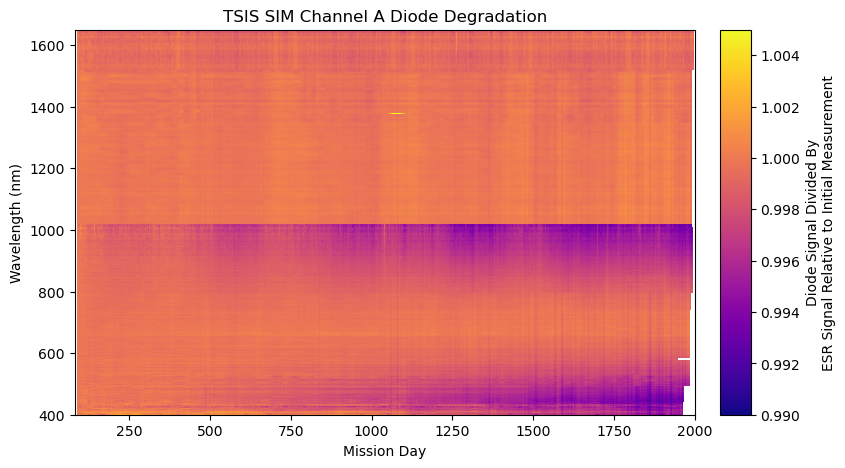

In [20]:
fig, ax=plt.subplots(1) #create new figure with one set of axes
cmap= mpl.cm.plasma #jet and RdYlBu are the other color display options
vmin=.99 #.85 is the original min but was changed to better show the cycle
vmax=1.005 #1.015 is same as .85
#da_ratio_interp_norm_uv.sel(wavelength = slice(260, 395)).plot(x = "scan_time", ax=ax, vmin=vmin,vmax=vmax, cmap=cmap, add_colorbar=False)
da_ratio_interp_norm_vis.sel(wavelength = slice(395, 1020)).plot(x = "scan_time", ax=ax, vmin=vmin,vmax=vmax, cmap=cmap, add_colorbar=False)
da_ratio_interp_norm_ir.sel(wavelength = slice(1020, 1650)).plot(x = "scan_time", ax=ax, vmin=vmin,vmax=vmax, cmap=cmap, add_colorbar=False)
ax.set_xlabel("Mission Day")
ax.set_ylabel("Wavelength (nm)")
ax.set_title("TSIS SIM Channel A Diode Degradation")
ax.set_ylim(400,1650)
fig.set_size_inches(8,5)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cax=ax.inset_axes([1.04, 0, .05, 1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              cax=cax, label='Diode Signal Divided By\nESR Signal Relative to Initial Measurement')


In [21]:
fig.savefig("channela.png", bbox_inches="tight")